# A quick demo for boundary context sample's feature analysis

This demo provides an analysis of how boundary context samples influence the predictive performance of FSVI, in terms of Expected Calibration Error (ECE) and out-of-distribution (OOD) detection.

We attribute these gains to the following two key contributions of the boundary samples:

- (A) Improving classifier's decision boundary discrimination capability.
- (B) Extending the OOD detection capability to a broader space.

This script provides the experimental process of the image classification task in Section V (Figs. 5 and 6 in the main paper). Other 2D analysis are avaliable in script `fsviContextSpecification.ipynb`.

⭐ We have saved all the features used in the experiment to the corresponding folder: `../output/kl_cost/cifar10CatHorse_(ctx){context_dataname}/features.pkl`, to facilitate quick experimental analysis. The features.pkl is a feature dictionary containing the following keys:

- `in_2d`: 2D features of in-distribution samples
- `ood_2d`: 2D features of OOD samples
- `ctx_2d`: 2D features of context samples
- `in_labels`: labels of in-distribution samples (0 or 1)
- `closest_ood_indices`: indices of the top-k (top-2) closest OOD samples to the in

⭐ See the `../contextFeatureGeneration.py` script for the BNN model's (constrained by different context sets) feature extraction source code. Detailed instructions for running this script can be found in the `../REAME.MD` file.

In [85]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from torch.utils.data import Subset, DataLoader

import data_loader
import models
import bayesianize.bnn as bnn
from helpers import seed_everything, visualize_dataloader

import pickle

In [86]:
def visualize_features(ctx_dataset, out_dataset):
    with open(f"../output/kl_cost/cifar10CatHorse_(ctx){ctx_dataset}/(ood){out_dataset}/features.pkl", "rb") as f:
        data = pickle.load(f)

    in_2d = data['in_2d']
    ood_2d = data['ood_2d']
    ctx_2d = data['ctx_2d']
    in_labels = data['in_labels']
    closest_ood_indices = data['closest_ood_indices']

    # plt.figure(figsize=(6, 6))
    mask0 = (in_labels == 0)
    mask1 = (in_labels == 1)
    plt.scatter(in_2d[mask0, 0], in_2d[mask0, 1],  c='cornflowerblue', s=20, alpha=1, label='In-Class 0', edgecolors='none')  # In-distribution class 0
    plt.scatter(in_2d[mask1, 0], in_2d[mask1, 1],  c='tomato', s=20, alpha=1, label='In-Class 1', edgecolors='none')  # In-distribution class 1
    if ctx_2d is not None:
        plt.scatter(ctx_2d[:, 0], ctx_2d[:, 1], c='limegreen', marker='*', s=25, alpha=1, label='Context', edgecolors='none')  # Context samples
    plt.scatter(ood_2d[:, 0], ood_2d[:, 1], c='gold', marker='x', s=15, alpha=0.9, label='OOD')  # OOD samples
    plt.scatter(ood_2d[closest_ood_indices, 0], ood_2d[closest_ood_indices, 1], c='gold', marker='X', s=230, alpha=1, label='Highlighted OOD', edgecolors='black', linewidths=1.5)  # Top-k closest OOD samples
    plt.scatter(ood_2d[closest_ood_indices, 0], ood_2d[closest_ood_indices, 1], facecolors='none', edgecolors='black', s=250, linewidths=2)
    if ctx_dataset == "none":
        plt.title(f"PSVI without context samples\n (OOD: {out_dataset})", fontsize=14)
    else:
        plt.title(f"FSVI with {ctx_dataset} context samples\n (OOD: {out_dataset})", fontsize=14)
    plt.legend()

## (a) Boundary samples improves classifier's decision boarder discrimination capability

Implementation details:

- **In-distribution samples:** We train a BNN binary classifier on cat (blue) and horse (red) images from the CIFAR10 dataset.
- **Context samples:** Different context sets $\mathcal{C}$ (generated by boundaryGAN or empirically specified) are employed to constrain the fSVI process.
- **_OOD samples:_** Lion (yellow) images from [ImageNet](https://ieeexplore.ieee.org/abstract/document/5206848/) are utilized as OOD samples.
- The hidden feature vectors of various images generated by the BNN classifier $q(\boldsymbol{\uptheta})$ are extracted and visualized in a 2D space using UMAP.


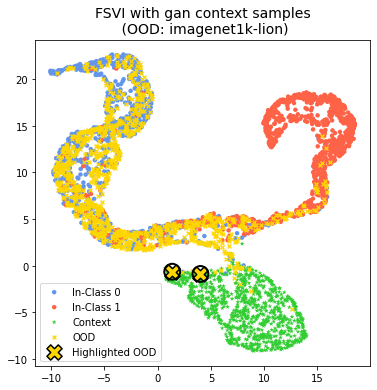

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6), gridspec_kw={'width_ratios': [1]})
plt.sca(axes)
visualize_features(ctx_dataset="gan", out_dataset="imagenet1k-lion")
plt.show()

**Result on our method:**

As shown in the figure above, the proposed boundary context set includes cat-like and horse-like images, allowing the two highlighted lion samples to be detected with high uncertainty (i.e., falling within the green region).

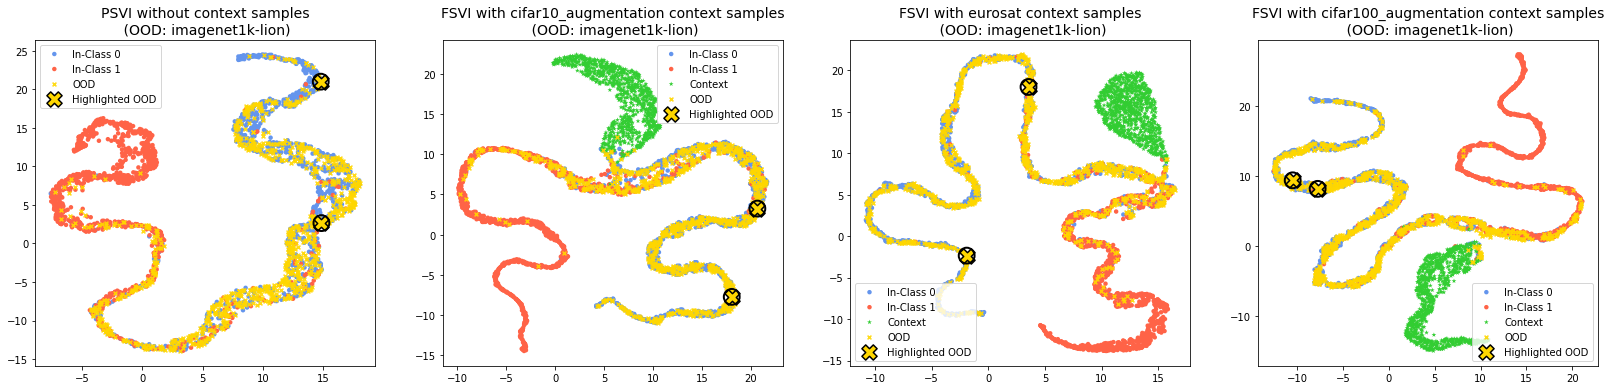

In [88]:
fig, axes = plt.subplots(1, 4, figsize=(28, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
plt.sca(axes[0])
visualize_features(ctx_dataset="none", out_dataset="imagenet1k-lion")
plt.sca(axes[1])
visualize_features(ctx_dataset="cifar10_augmentation", out_dataset="imagenet1k-lion")
plt.sca(axes[2])
visualize_features(ctx_dataset="eurosat", out_dataset="imagenet1k-lion")
plt.sca(axes[3])
visualize_features(ctx_dataset="cifar100_augmentation", out_dataset="imagenet1k-lion")
plt.show()

**Result on the empirically specified context sets:**

In contrast, the figures above demonstrate that empirically selected context sets fail to cover these ambiguous inputs, leading the lion samples to fall into the blue region and be overconfidently predicted as cats.

# (b) Boundary samples extends the OOD detection capability to a broader space

Implementation details:

- **In-distribution samples:** We train a BNN binary classifier on cat (blue) and horse (red) images from the CIFAR10 dataset.
- **Context samples:** Different context sets $\mathcal{C}$ (generated by boundaryGAN or empirically specified) are employed to constrain the fSVI process.
- **_OOD samples:_** Here, OOD data comes from [TinyImageNet](https://ieeexplore.ieee.org/abstract/document/5206848/), which is far from the training distribution and includes 200 diverse object categories (e.g., landscapes).
- UMAP is also utilized to visualize the hidden feature vectors of various images.


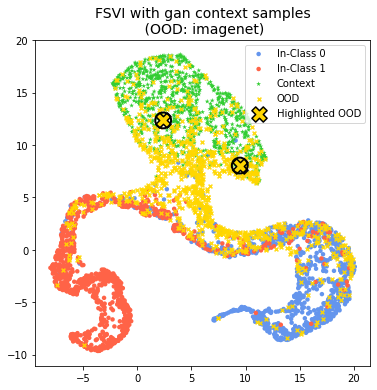

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6), gridspec_kw={'width_ratios': [1]})
plt.sca(axes)
visualize_features(ctx_dataset="gan", out_dataset="imagenet")
plt.show()

**Result on our method:**

As shown in the figure above, the influence of cat-like and horse-like boundary samples spreads to an extensive feature space, enabling the yellow region to be covered by the green one as much as possible.

For instance, the "two highlighted landscape images" fall within the region covered by the boundary context sets, and thus can be distinguished with high uncertainty.

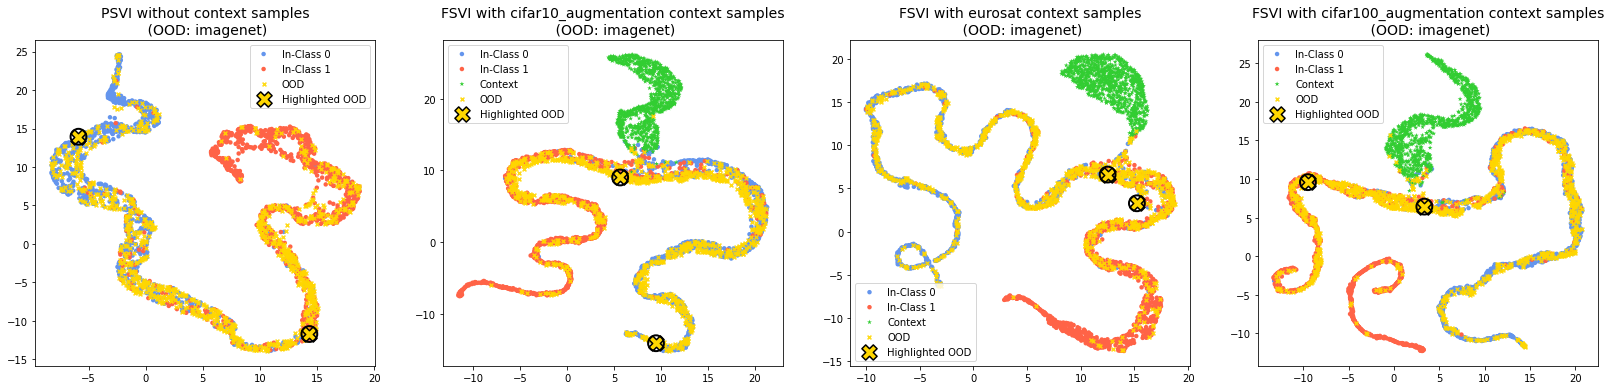

In [90]:
fig, axes = plt.subplots(1, 4, figsize=(28, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
plt.sca(axes[0])
visualize_features(ctx_dataset="none", out_dataset="imagenet")
plt.sca(axes[1])
visualize_features(ctx_dataset="cifar10_augmentation", out_dataset="imagenet")
plt.sca(axes[2])
visualize_features(ctx_dataset="eurosat", out_dataset="imagenet")
plt.sca(axes[3])
visualize_features(ctx_dataset="cifar100_augmentation", out_dataset="imagenet")
plt.show()

**Result on the empirically specified context sets:**

In contrast, the empirically specified context sets above are only distributed within a narrow OOD space, leading most yellow OOD samples to be overconfidently predicted as cat or dog.